<h1> Identifying Driver Classes to Estimate the Safety Benefits of AI Semi-Autonomous Vehicle Technologies </h1>

<strong> Author: Micah Simmerman, Nolan Ollada, Nathan Palmer </strong>

<strong>Resource URL:</strong>

<strong>Database file(s), columnar dataset(s), etc.:</strong>

# Project Description
This project will investigate data mining techniques for efficient isolation of principle classes hidden inside massive datasets (i.e., those containing millions of data points or more). This project will identify a series of robust and sequential data mining techniques that can be used to extract, clean, normalize, and prepare the data for causal analysis. Our investigation will use Principal Component Analysis (PCA) and apriori-based Data Cube techniques to observe temporal and regional trends in automotive safety. We will use the insight derived from these Data Cubes to identify and predict the principal driver classes composing the SWITRS California Collision Data Set using Decision Tree Classification (DTC), Frequent Pattern Mining (FPM), and Bayesian Belief Networks (BBN). The project will conclude with a k-fold cross validation or/or cluster based data discovery  to estimate the accuracy and usefulness of each model.

In [2]:
# Libraries and packages
import os
import sqlite3
import pandas as pd
pd.__version__
import numpy as np
# from sklearn import datasets  # contains the iris data set, among other things.
from sklearn import decomposition, datasets
from sklearn.decomposition import PCA  # Super important for sklearn PCA
from sklearn.preprocessing import MinMaxScaler # For normalization
from sklearn.preprocessing import StandardScaler
from scipy import stats
from collections import Counter
import math
import seaborn as sns
import matplotlib.pyplot as plt

# SQLite db file connection is achieved in the try/except statements below. 
# TODO: add sections to read-in mySQL/PostGreSQL and csv files.

tables = []  # GLOBAL TABLE INDEX
attribute_list = []  # GLOBAL ATTRIBUTE INDEX

# NOTE: always store the switrs.sqlite file in the parent directory where this python notebook is kept.
db_file = '../switrs.sqlite'  # name the db file downloaded directly from https://www.kaggle.com/datasets/alexgude/california-traffic-collision-data-from-switrs
sqliteConnection = sqlite3.connect(db_file)

# if os.path.isfile(db_file):  # determine if there is any SQLite db file by that name exists in the specified file location.
sqliteConnection = sqlite3.connect(db_file)  # establish a connection if the file does exist.
cursor = sqliteConnection.cursor()  # create a cursor object.
table_query = 'SELECT name from sqlite_master where type= "table"'
cursor.execute(table_query)
result = cursor.fetchall()
print()
print(len(result), "tables found.")
for i in range(len(result)):
    tables.append(result[i][0])
    # print(result[i][0])

# the second part of the algorithm extracts the attributes of each table identified in the first step and places them into a 2D list. 
for table in tables:
    consumer_complaints_count_records = "PRAGMA table_info("
    consumer_complaints_count_records += str(table)  + ");"  # build the sqlite query string using the current list object
    cursor.execute(consumer_complaints_count_records)  # execute the query string
    result = cursor.fetchall()  # collect the results
    temp_list = []
    for item in result:
        temp_list.append(item[1])
    attribute_list.append(temp_list)  # export the list attribute table after it is built
    # print("The", table, "table contains", result[0][0], "data points")  # print the results
    # print()
print("Table and attribute name extraction completed successfully.")


print('DB file and Dependencies Loaded.')  
# else:
#     print(os.path.isfile(db_file), "No SQLite file detected.")  # otherwise, print the connection status.


4 tables found.
Table and attribute name extraction completed successfully.
DB file and Dependencies Loaded.


Start by collecting information about the table names in the database.

In [3]:
# Now we have a list of tables and their respective attribute columns.
print("Tables in the database: ", tables)
print("Attribute list: ", attribute_list)

Tables in the database:  ['case_ids', 'collisions', 'victims', 'parties']
Attribute list:  [['case_id', 'db_year'], ['case_id', 'population', 'county_city_location', 'county_location', 'primary_road', 'secondary_road', 'distance', 'direction', 'intersection', 'weather_1', 'weather_2', 'location_type', 'ramp_intersection', 'tow_away', 'collision_severity', 'killed_victims', 'injured_victims', 'party_count', 'primary_collision_factor', 'pcf_violation_code', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'statewide_vehicle_type_at_fault', 'chp_vehicle_type_at_fault', 'severe_injury_count', 'other_visible_injury_count', 'complaint_of_pain_injury_count', 'pedestrian_killed_count', 'pedestrian_injured_count', 'bicyclist_killed_count', 'bicyclist_

## Data Cleaning and Preprocessing
run the code below to remove the attributes in the remove_cols_collisions and remove_cols_parties tables specified. You can run the above 2 code blocks again to see that the specified attributes were removed.

Running the following cell twice currently results in an error. 

    RATIONAL FOR ATTRIBUTE COLUMN REMOVAL:
    collisions.officer_id: responding officers identification is not relevant to the factors of a collision.
    collisions.chp_shift: chp_shift indicates the work shift period of the responding officer. More accurate temporal measurements exist.
    collisions.special_condition: 
    collisions.beat_type: 
    collisions.city_division_lapd: 
    collisions.chp_beat_class: 
    collisions.beat_number: 
    collisions.pcf_violation: 
    collisions.pcf_violation_subsection: 
    collisions.hit_and_run: 
    collisions.process_date: 

    For a complete list of attribute definitions, please visit: https://peteraldhous.com/Data/ca_traffic/SWITRS_codebook.pdf

# Warning:
The following cell block removes unwanted attribute columns from the SWITRS database file and will take a long time to execute. Repeated requests should not impose any harm on the database file. Time to complete last session = 14 minutes. 

In [4]:
# Increase the page count and turn off SQLite Journaling Mode to reduce the overhead of the SQLite ALTER TABLE statements.
increase_page_count = "PRAGMA max_page_count = 2147483646;"
turn_off_journal = "PRAGMA journal_mode=OFF"
cursor.execute(increase_page_count)
cursor.execute(turn_off_journal)  # turn off the journaling mode (temporarily) to avoid exceeding local disk space limitations.
sqliteConnection.commit()

In [5]:
# PLACE AN INDEX ON 'case_id' IN ALL THREE TABLES TO FACILITATE DRILL-THROUGH QUERIES. 
try:
    set_case_id_index_collisions = "CREATE INDEX collisions_case_id ON collisions(case_id);"
    set_case_id_index_parties = "CREATE INDEX parties_case_id ON parties(case_id);"
    set_case_id_index_victims = "CREATE INDEX victims_case_id ON victims(case_id);"
    cursor.execute(set_case_id_index_collisions)
    cursor.execute(set_case_id_index_parties)
    cursor.execute(set_case_id_index_victims)
    sqliteConnection.commit()
except:
    print("SWITRS DB file contains the following indices...") 
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("collisions table index 'collisions_case_id' created on 'case_id' attribute column.") 
    print("parties table index 'parties_case_id' created on 'case_id' attribute column.")
    print("victims table index 'victims_case_id' created on 'case_id' attribute column.")

SWITRS DB file contains the following indices...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
collisions table index 'collisions_case_id' created on 'case_id' attribute column.
parties table index 'parties_case_id' created on 'case_id' attribute column.
victims table index 'victims_case_id' created on 'case_id' attribute column.


In [6]:
# Include the attribute columns you wish to remove in the list(s) below.
remove_cols_collisions = ["side_of_highway", "road_condition_2", "primary_ramp", "secondary_ramp", "jurisdiction", "chp_beat_type", "reporting_district", "state_highway_indicator", "caltrans_county", "caltrans_district", "state_route", "route_suffix", "postmile_prefix", "postmile", "chp_road_type", "officer_id", "chp_shift", "special_condition", "beat_type", "city_division_lapd", "chp_beat_class", "beat_number", "pcf_violation", "pcf_violation_subsection", "hit_and_run", "process_date"]
remove_cols_parties = ["hazardous_materials", "oaf_violation_code"]
# Alternatively, we can identify the attribute ids with a string and concatenate it into a SQLite query statement.
# remove_cols_collisions = "officer_id, chp_shift, special_condition, beat_type, city_division_lapd, chp_beat_class, beat_number, pcf_violation, pcf_violation_subsection, hit_and_run, process_date"
# remove_cols_parties = "hazardous_materials, oaf_violation_code"

try:
    for col in remove_cols_collisions:
        drop_collisions_columns = "ALTER TABLE collisions DROP  "
        drop_collisions_columns += col  + ";" 
        cursor.execute(drop_collisions_columns)
        sqliteConnection.commit()
        print("Removed", col, "from the 'collisions' table.")
        print("working...")
    for attrib in remove_cols_parties:
        drop_parties_columns = "ALTER TABLE parties DROP "
        drop_parties_columns += attrib  + ";" 
        cursor.execute(drop_parties_columns)
        sqliteConnection.commit()
        print("Removed", attrib, "from the 'parties' table")
        print("working...")
    print("The identified attribute columns successfully removed from the switrs database file.")
    print("Overwrite ../switrs.sqlite with a newly decompressed switrs source file to reverse these changes")
except:
    print("These columns have been removed already.")

## CODE FOR RESTORING JOURNAL MODE (DEFAULT = OFF)
# turn_journal_on = "PRAGMA journal_mode=ON"  # let's leave this off for now. 
# cursor.execute(turn_journal_on)  # turn the journaling mode back on so we can roll-back our changes.
# sqliteConnection.commit()  # commit the change to the database file.
# print("journal mode is back on.")

These columns have been removed already.


In [7]:
# Now we have a list of tables and their respective attribute columns.+
for i in range(len(tables)):
    print(tables[i], "has attributes:", attribute_list[i])
    # print(attribute_list[i])
    

case_ids has attributes: ['case_id', 'db_year']
collisions has attributes: ['case_id', 'population', 'county_city_location', 'county_location', 'primary_road', 'secondary_road', 'distance', 'direction', 'intersection', 'weather_1', 'weather_2', 'location_type', 'ramp_intersection', 'tow_away', 'collision_severity', 'killed_victims', 'injured_victims', 'party_count', 'primary_collision_factor', 'pcf_violation_code', 'pcf_violation_category', 'type_of_collision', 'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface', 'road_condition_1', 'lighting', 'control_device', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 'truck_collision', 'not_private_property', 'alcohol_involved', 'statewide_vehicle_type_at_fault', 'chp_vehicle_type_at_fault', 'severe_injury_count', 'other_visible_injury_count', 'complaint_of_pain_injury_count', 'pedestrian_killed_count', 'pedestrian_injured_count', 'bicyclist_killed_count', 'bicyclist_injured_count', 'motorcyclist_killed_coun

In [8]:
# ENUMERATE DATA POINTS
data_point_count = 0
for table in range(len(tables)):
    count_records = 'SELECT COUNT(*) FROM ('  # start the string.
    count_records += tables[table] + ");"  # concatenate the variable and complete the string build.
    cursor.execute(count_records)  # 
    result = cursor.fetchall()
    data_point_count += result[0][0]
    print("The", tables[table], "table contains", result[0][0], "data points.")

print("Current number of data points accross tables of 'switrs.sqlite' database file =", data_point_count)

The case_ids table contains 9424334 data points.
The collisions table contains 9424334 data points.
The victims table contains 9639334 data points.
The parties table contains 18669166 data points.
Current number of data points accross tables of 'switrs.sqlite' database file = 47157168


### Training/Test Set Generation Using Random Data Point Sampling

Below, we create a Pandas DataFrame by pulling 10,000 samples at random from the switrs collisions table. We then extract these case_id's into a python list and use it to execute a set-based SQLite query to pull in the points from the other database tables. Doing this dramatically increases the performance of these queries. The representative data extracted from these columns is then used for data cleaning, nominal attribute quantification, and the application of normalizing functions (such as z-score) on numerical attribute columns to support common PCA libraries such as sklearn.

Note that the code blocks below can be used to triangulate on data points based on the multiple attributes you can examine in each representative dataframe. As an exmaple, suppose you wish to locate victims of a car accident who were fully-ejected from their vehicle as a result of failure to fasten a safety belt. To locate such an object, one might perform the following queries on the 'victims_matching_10000_training_df' data frame to examine a representative sample collected at random from the 'victims' switrs.sqlite database file. The following queries may be used to locate such a datapoint within the set. 

    # TAKE A LOOK AT A SPECIFIC COLUMN(S)
    print("BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_safety_equipment_2']")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(victims_matching_10000_training_df.loc[:,"victim_safety_equipment_2"])
    print()
    print("BEGIN: Examine victims_matching_10000_training_df.loc[:,'victim_ejected']")
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(victims_matching_10000_training_df.loc[:,"victim_ejected"])

The code within this block populates the case_id list object with the case_id values collected in the random sample procedure. This list is then used to perform a set selection using a "SELECT FROM WHERE case_id IN ..." type SQLite query construction. The nature of set queries and generation of the index on the 'case_id' attribute column of each table makes this a very speedy query set. 

####  Generating the n=10,000 Training Sets (PANDAS data frames) Using Random Sampling w/o Replacement

The following code sections produce three (n=10,000) random sample dataframes, composed of matching data points from the 'collisions', 'parties', and 'victims' tables by using a 'case_id' sampling index, kept in the form of a python list 'n_10000_training_set_case_ids' in the cell below.

In [9]:
# Create a python list of the 'case_id' values for the n=10,000 random sample set that we are about to generate.
n_10000_training_set_case_ids = []  # this list will contain each 'case_id'

# The estimated completion time is 20.5 seconds.
print("Generating a n=10,000 random-sample training set from the 'collisions' table of the switrs.sqlite database file...")
print("#####################################################################################################")
# Read 10000 random samples from the collisions table into a local pandas DataFrame. (BOOTSTRAP SAMPLING)
collisions_n_10000_training_set_df = pd.read_sql_query("SELECT * FROM collisions ORDER BY RANDOM() LIMIT 10000;", sqliteConnection)
# sort the data frame in ascending order of case_id
collisions_n_10000_training_set_df.sort_values(by=['case_id'], ascending=True, kind='quicksort', na_position='last', ignore_index=False, key=None)# sort the df in row ascending order of case_id

print()
print("collisions_random_10000_df.head()...")
print(collisions_n_10000_training_set_df.head())
print(collisions_n_10000_training_set_df['case_id'].values[0])

# populate the case_ids list
for i in collisions_n_10000_training_set_df.index:
    n_10000_training_set_case_ids.append(collisions_n_10000_training_set_df['case_id'].values[i])

# Check our progress.
print("SAMPLE 'n_10000_training_set_case_ids':")
print(n_10000_training_set_case_ids)  # USE THIS LIST TO CALL THE DATA OBJECTS IN FROM THE OTHER TABLES (I.e., 'parties' and 'victims'). 

Generating a n=10,000 random-sample training set from the 'collisions' table of the switrs.sqlite database file...
#####################################################################################################

collisions_random_10000_df.head()...
   case_id       population county_city_location county_location  \
0  3933674   25000 to 50000                 4403      santa cruz   
1  7204193   25000 to 50000                 1910     los angeles   
2  2383089   unincorporated                 3100          placer   
3  0340403  50000 to 100000                 3040          orange   
4  8059667  50000 to 100000                 1952     los angeles   

      primary_road   secondary_road  distance direction  intersection  \
0  GREEN VALLEY RD  GREEN MEADOW DR       0.0      None           1.0   
1     W OLYMPIC BL       S CLARK DR       0.0      None           1.0   
2        TAYLOR RD   LEMOS RANCH DR    2112.0     south           0.0   
3        CANTABURY          AUGUSTA     148.

In [10]:
# Estimated cell runtime: 0.5 seconds
## This cell runs lightning fast (approximately 4 seconds) because of its' set-based query and the index placed on case_id in each table.
## Here, we are building a tuple-formatted string containing the case_id's we are interested in collecting from switrs. We close the argument at the end of the paragraph.
training_set_case_ids = "("  # we will close this when we append the other argument strings.
for i in n_10000_training_set_case_ids:  # scan through the training set case_id's.
    training_set_case_ids += i  # append each case_id we find to the sql query string.
    training_set_case_ids += ", "  # delete this substring before closing the string.
training_set_case_ids = training_set_case_ids[:-2]  # 
training_set_case_ids += ") ORDER BY case_id DESC;"

# Complete each of the sql queries
parties_query = "SELECT * FROM parties WHERE case_id IN " + training_set_case_ids
victims_query = "SELECT * FROM victims WHERE case_id IN " + training_set_case_ids

# PULL IN THE CORRESPONDING RECORDS FROM 'parties' and 'victims' TABLES
parties_matching_10000_training_df = pd.read_sql_query(parties_query, sqliteConnection)
victims_matching_10000_training_df = pd.read_sql_query(victims_query, sqliteConnection)

# Check our work
print("Generating a n=10,000 random-sample training set from the 'parties' table of the switrs.sqlite database file...")
print("#######################################################")
print(".head() view of the 'parties_matching_10000_training_df' dataframe object:")
print(parties_matching_10000_training_df.head())
print("END")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()
print("Generating a n=10,000 random-sample training set from the 'victims' table of the switrs.sqlite database file...")
print("#######################################################")
print(".head() view of the 'victims_matching_10000_training_df' dataframe object:")
print(victims_matching_10000_training_df.head())
print("END")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()

Generating a n=10,000 random-sample training set from the 'parties' table of the switrs.sqlite database file...
#######################################################
.head() view of the 'parties_matching_10000_training_df' dataframe object:
         id  case_id  party_number      party_type  at_fault party_sex  \
0  10492063  9269291             2  parked vehicle         0      None   
1  10492062  9269291             1          driver         1      None   
2  10490383  9268142             3  parked vehicle         0      None   
3  10490382  9268142             2  parked vehicle         0      None   
4  10490381  9268142             1          driver         1    female   

   party_age      party_sobriety party_drug_physical direction_of_travel  ...  \
0        NaN      not applicable      not applicable                east  ...   
1        NaN  impairment unknown                   G                east  ...   
2        NaN                None                None                N

###  Generating the n=10,000 Test Sets (PANDAS data frames) using Random Sampling w/o Replacement

Next, we will generate another series of n=10,000 dataframes that we will use to evalutate the assumptions of our models with. To enforce random sampling without replacement, we will exlcude samples in 'case_ids' from consideration in the SQLite query.

In [11]:
# Approximate time to complete this cell = 24 seconds.
n_10000_test_set_case_ids = []  # similar to 'training_case_ids'

# 
print("Generating an N=10,000 random data point test set, composed of collisions table data objects from the switrs.sqlite database file.")
print("Working...")

# Build a tuple formatted string that contains the case_id's we are interested in and leave out those we are not.
case_ids_not_in_test_set = "("  # we will close this when we append the other argument strings.
for i in n_10000_training_set_case_ids:  # append every case_id included in the training set. 
    case_ids_not_in_test_set += i  # append it to the tuple formatted sql string argument.
    case_ids_not_in_test_set += ", "  # delete this substring before closing the string.
case_ids_not_in_test_set = case_ids_not_in_test_set[:-2]  # cut off the last two chars.
case_ids_not_in_test_set += ") ORDER BY RANDOM() LIMIT 10000;"  # complete the sqlite statement.

# This sql query demonstrates the logic behind the "random sampling without replacement" scheme. 
collisions_test_set_query = "SELECT * FROM collisions WHERE case_id NOT IN " + case_ids_not_in_test_set  # exclude training set members

# Use the sql query response to populate the 'collisions_n_10000_test_set_df' data frame object.
collisions_n_10000_test_set_df = pd.read_sql_query(collisions_test_set_query, sqliteConnection)
collisions_n_10000_test_set_df.sort_values(by=['case_id'], ascending=True, kind='quicksort', na_position='last', ignore_index=False, key=None)# sort the df in ascending order of case_id

# Check our work
print("(n=10,000) data frame formed with randomly selected 'collisions' table test tuples. These case id's compose the test set.")
print("#######################################################")
print(".head() view of the 'parties_matching_10000_df' test set dataframe object:")
print(collisions_n_10000_test_set_df.head())

# populate the 'test_case_ids' list
for i in collisions_n_10000_test_set_df.index:
    n_10000_test_set_case_ids.append(collisions_n_10000_test_set_df['case_id'].values[i])
    
print("collisions_n_10000_test_set_df.head()...")
print(collisions_n_10000_test_set_df.head())

print(n_10000_test_set_case_ids)

Generating an N=10,000 random data point test set, composed of collisions table data objects from the switrs.sqlite database file.
Working...
(n=10,000) data frame formed with randomly selected 'collisions' table test tuples. These case id's compose the test set.
#######################################################
.head() view of the 'parties_matching_10000_df' test set dataframe object:
    case_id        population county_city_location county_location  \
0   3521247    unincorporated                 3300       riverside   
1  90284339  100000 to 250000                 0105         alameda   
2   4454163           >250000                 1942     los angeles   
3   5083005   50000 to 100000                 4311     santa clara   
4   1415952    25000 to 50000                 3018          orange   

      primary_road   secondary_road  distance direction  intersection  \
0        GALENA ST  SADDLE CREEK DR       2.0      east           0.0   
1        PEPYS WAY      GAURDINO DR   

In [12]:
# Now we need to build the other two test set data frames.
test_set_case_ids = "("  # we will close this when we append the other argument strings.
for i in n_10000_test_set_case_ids:
    test_set_case_ids += i 
    test_set_case_ids += ", "  # delete this substring before closing the string.
test_set_case_ids = test_set_case_ids[:-2]  # 
test_set_case_ids += ") ORDER BY case_id DESC;"

# Complete each of the sql queries
parties_query = "SELECT * FROM parties WHERE case_id IN " + test_set_case_ids
victims_query = "SELECT * FROM victims WHERE case_id IN " + test_set_case_ids

collisions_n_10000_test_set_df

# PULL IN THE CORRESPONDING RECORDS FROM 'parties' and 'victims' TABLES
parties_matching_n_10000_test_set_df = pd.read_sql_query(parties_query, sqliteConnection)
victims_matching_n_10000_test_set_df = pd.read_sql_query(victims_query, sqliteConnection)

# Check our work
print("(n=10,000) data frame composed of 'parties' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'")
print("#######################################################")
print(".head() view of the 'parties_matching_n_10000_test_set_df' dataframe object:")
print(parties_matching_n_10000_test_set_df.head())
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print()
print("(n=10,000) data frame composed of 'victims' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'")
print("#######################################################")
print(".head() view of the 'victims_matching_n_10000_test_set_df' dataframe object:")
print(victims_matching_n_10000_test_set_df.head())

(n=10,000) data frame composed of 'parties' table tuples, associated with 'case_id's found in 'collisions_random_10000_df'
#######################################################
.head() view of the 'parties_matching_n_10000_test_set_df' dataframe object:
         id  case_id  party_number      party_type  at_fault party_sex  \
0  10491523  9268961             3  parked vehicle         0      None   
1  10491522  9268961             2          driver         0      male   
2  10491521  9268961             1          driver         1      None   
3  10486576  9264759             2          driver         0      male   
4  10486575  9264759             1          driver         1      male   

   party_age         party_sobriety party_drug_physical direction_of_travel  \
0        NaN                   None                None                None   
1       21.0         not applicable      not applicable                west   
2        NaN                   None                None       

### Eliminating the Irrelevant Attributes

Use the cells below to evaluate the attribute columns of each table to smooth, normalize, and/or mark attribute columns for removal.

#### Examining collisions_n_10000_training_set_df

In [13]:
# TAKE A CLOSE LOOK AT THE collisions_n_10000_training_set_df DATAFRAME OBJECT (COLUMNS MANAGED WITH SQL)
print("BEGIN collisions_n_10000_training_set_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.info())
print("END collisions_n_10000_training_set_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN collisions_n_10000_training_set_df.head()")
print(parties_matching_10000_training_df.head())

# 
print("###################################################################################")
columns = list(collisions_n_10000_training_set_df.columns)
print("List of remaining columns in collisions_n_10000_training_set_df:")
print(columns)


BEGIN collisions_n_10000_training_set_df.info()
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_id                          10000 non-null  object 
 1   population                       9998 non-null   object 
 2   county_city_location             10000 non-null  object 
 3   county_location                  10000 non-null  object 
 4   primary_road                     10000 non-null  object 
 5   secondary_road                   10000 non-null  object 
 6   distance                         10000 non-null  float64
 7   direction                        7511 non-null   object 
 8   intersection                     9905 non-null   float64
 9   weather_1                        9959 non-null   object 
 10  weather_2  

### Address NULL Collision Values

In [14]:
# Start with Numeric Attributes
numeric_collision_columns = collisions_n_10000_training_set_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_collision_columns:
    print("Column:", col)
    print(collisions_n_10000_training_set_df[col].value_counts())
    print("\n")
# Most of the numeric columns can have 0 filled in for their NaN values. Lets deal with special cases first.

# PARTY COUNT: The most common and intuitive value for this will be 2. 
collisions_n_10000_training_set_df['party_count'] = collisions_n_10000_training_set_df['party_count'].fillna(2)
# For the rest of the columns, it makes most sense to fill NaN with 0. 
# Note: filling Latitude and Longitude with 0 doesnt make much logical sense, but for the sake of avoiding errors when using them for calulations, we will fill with 0.
# If using Lat and Long in the future, consider excluding entries with 0 value.
for col in numeric_collision_columns:
    collisions_n_10000_training_set_df[col] = collisions_n_10000_training_set_df[col].fillna(0)

Column: distance
distance
0.0       2522
100.0      363
200.0      271
528.0      233
50.0       219
          ... 
454.0        1
473.0        1
336.0        1
3500.0       1
4171.0       1
Name: count, Length: 889, dtype: int64


Column: intersection
intersection
0.0    7595
1.0    2310
Name: count, dtype: int64


Column: tow_away
tow_away
1.0    5051
0.0    4870
Name: count, dtype: int64


Column: killed_victims
killed_victims
0.0    9907
1.0      80
2.0       4
3.0       3
4.0       2
Name: count, dtype: int64


Column: injured_victims
injured_victims
0.0     6106
1.0     2725
2.0      767
3.0      245
4.0       95
5.0       26
6.0       19
7.0        7
9.0        2
11.0       1
8.0        1
18.0       1
Name: count, dtype: int64


Column: party_count
party_count
2.0     6798
1.0     1879
3.0     1045
4.0      217
5.0       42
6.0       14
7.0        3
15.0       1
Name: count, dtype: int64


Column: pedestrian_collision
pedestrian_collision
0    9725
1     275
Name: count, dtype: 

In [15]:
# EXAMINE THE DATA SET
print("BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'collision_date']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.loc[:,"collision_date"])
print()
print("BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'ramp_intersection']")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.loc[:,"ramp_intersection"])

# List of safe columns to drop: [INCLUDE ATTRIBUTE COLUMNS TO DROP HERE] 

BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'collision_date']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0       2008-10-28
1       2015-03-25
2       2005-11-30
3       2002-07-27
4       2016-04-18
           ...    
9995    2016-01-24
9996    2008-09-16
9997    2011-11-13
9998    2007-01-27
9999    2008-11-29
Name: collision_date, Length: 10000, dtype: object

BEGIN: Examine collisions_n_10000_training_set_df.loc[:,'ramp_intersection']
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0       None
1       None
2       None
3       None
4       None
        ... 
9995    None
9996    None
9997    None
9998    None
9999    None
Name: ramp_intersection, Length: 10000, dtype: object


#### Examining the 'parties' Table Using 'parties_matching_10000_training_df'

In [16]:
# TAKE A CLOSE LOOK AT THE 'parties_matching_10000_training_df' DATAFRAME OBJECT (COLUMNS MANAGED WITH SQL)
print("BEGIN: Examine 'parties_matching_10000_training_df' df using '.info()'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(parties_matching_10000_training_df.info())
print("END: parties_matching_10000_training_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN parties_matching_10000_training_df.head()")
print(parties_matching_10000_training_df.head())

# 
print("###################################################################################")
columns = list(parties_matching_10000_training_df.columns)
print("List of remaining columns in parties_matching_10000_training_df:")
print(columns)

BEGIN: Examine 'parties_matching_10000_training_df' df using '.info()'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17570 entries, 0 to 17569
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            17570 non-null  int64  
 1   case_id                       17570 non-null  object 
 2   party_number                  17570 non-null  int64  
 3   party_type                    17543 non-null  object 
 4   at_fault                      17570 non-null  int64  
 5   party_sex                     15130 non-null  object 
 6   party_age                     14757 non-null  float64
 7   party_sobriety                17073 non-null  object 
 8   party_drug_physical           2965 non-null   object 
 9   direction_of_travel           17046 non-null  object 
 10  party_safety_equipment_

### Address NULL Party Values

In [17]:
# Start with Numeric Attributes
numeric_parties_columns = parties_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_parties_columns:
    print("Column:", col)
    print(parties_matching_10000_training_df[col].value_counts())
    print("\n")
# Most of the numeric columns can have 0 filled in for their NaN values. Lets deal with special cases first.
# ID: lets just leave this alone
# PARTY NUMBER: leave this alone
# PARTY AGE: Lets fill with missing values with the mean party age
mean_age = parties_matching_10000_training_df['party_age'].mean()
parties_matching_10000_training_df['party_age'].fillna(mean_age, inplace=True)
# For the rest of the columns, it makes most sense to fill NaN with 0. 
# Note: dont touch ID or PARTY NUMBER as these could create unintentional results and it wont be needed for calculations

# Get all column names except 'id' and 'party_number'
parties_cols_to_fill = [col for col in parties_matching_10000_training_df.columns if col not in ['id', 'party_number']]

# Fill missing values in these columns with 0
parties_matching_10000_training_df[parties_cols_to_fill] = parties_matching_10000_training_df[parties_cols_to_fill].fillna(0)

Column: id
id
2985602    2
5662401    2
2947523    2
2947522    2
4238507    2
          ..
5130647    1
5130646    1
5130645    1
5130644    1
1803079    1
Name: count, Length: 17560, dtype: int64


Column: party_number
party_number
1     8856
2     7189
3     1193
4      247
5       55
6       18
7        4
15       1
14       1
13       1
12       1
11       1
10       1
9        1
8        1
Name: count, dtype: int64


Column: at_fault
at_fault
0    9415
1    8155
Name: count, dtype: int64


Column: party_age
party_age
21.0    485
19.0    471
22.0    450
20.0    437
23.0    424
       ... 
1.0       1
99.0      1
95.0      1
92.0      1
4.0       1
Name: count, Length: 98, dtype: int64


Column: cellphone_in_use
cellphone_in_use
0.0    12974
1.0      258
Name: count, dtype: int64


Column: school_bus_related
school_bus_related
1.0    73
Name: count, dtype: int64


Column: party_number_killed
party_number_killed
0    17494
1       68
2        3
3        3
4        2
Name: count, dty

In [18]:
# Identify the numeric columns fo the parties training set dataframe.
parties_cols_to_scale = parties_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
parties_cols_to_scale = [col for col in parties_cols_to_scale if col not in ['id', 'party_number']]
print("parties_cols_to_scale", parties_cols_to_scale)

parties_cols_to_scale ['at_fault', 'party_age', 'cellphone_in_use', 'school_bus_related', 'party_number_killed', 'party_number_injured', 'vehicle_year']


#### Examinine the quality of data cleaning and smoothing.

### Address NULL Victim Values

In [19]:
# Start with Numeric Attributes
numeric_victims_columns = victims_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
for col in numeric_victims_columns:
    print("Column:", col)
    print(victims_matching_10000_training_df[col].value_counts())
    print("\n")

# ID: lets just leave this alone
# VICTIM NUMBER: leave this alone
# VICTIM AGE: Lets fill with missing values with the mean party age
mean_age = victims_matching_10000_training_df['victim_age'].mean()
victims_matching_10000_training_df['victim_age'].fillna(mean_age, inplace=True)
# There are no more numeric attributes
# Note: dont touch ID or PARTY NUMBER as these could create unintentional results and it wont be needed for calculations

Column: id
id
4445950    2
1102705    2
1102704    2
2264316    2
3064649    2
          ..
2372293    1
2376209    1
2376981    1
2378919    1
1028669    1
Name: count, Length: 8964, dtype: int64


Column: party_number
party_number
2    4200
1    4097
3     562
4      77
5      24
6       6
7       3
Name: count, dtype: int64


Column: victim_age
victim_age
19.0     282
21.0     275
18.0     257
20.0     247
17.0     225
        ... 
122.0      1
103.0      1
105.0      1
102.0      1
999.0      1
Name: count, Length: 100, dtype: int64




In [20]:
# making df to scale because we want to exclude id and party_number
victim_cols_to_scale = victims_matching_10000_training_df.select_dtypes(include=['float64', 'int64']).columns
victim_cols_to_scale = [col for col in victim_cols_to_scale if col not in ['id', 'party_number']]

### Examine the resulting attribute outcomes.

In [21]:
# OBSERVE THE EFFECTS OF DATA CLEANING AND DATA SMOOTHING ON THE TRAINING SET DATA FRAMES:

# # USE THE CODE BELOW TO EXPLORE INTERESTING ATTRIBUTES IN ANY OF THE AVAILABLE DATAFRAMES.
# print("BEGIN: Examine parties_matching_10000_training_df.loc[:,'movement_preceding_collision']")
# print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# print(parties_matching_10000_training_df.loc[:,"movement_preceding_collision"])  # interesting attribute
# print()
# print("BEGIN: Examine parties_matching_10000_training_df.loc[:,'cellphone_in_use']")
# print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# print(parties_matching_10000_training_df.loc[:,"cellphone_in_use"])


# SUMMARIZE DATA FRAMES WITH '.info()'
# collisions_n_10000_training_set_df.info, collisions_n_10000_training_set_df.head()
print("BEGIN: Examine 'collisions_n_10000_training_set_df' df using '.info()'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(collisions_n_10000_training_set_df.info())
print("END collisions_n_10000_training_set_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN collisions_n_10000_training_set_df.head()")
print(collisions_n_10000_training_set_df.head())

# parties_matching_10000_training_df.info(), parties_matching_10000_training_df.head()
print("BEGIN: Examine 'parties_matching_10000_training_df' df using '.info()'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(parties_matching_10000_training_df.info())
print("END parties_matching_10000_training_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN parties_matching_10000_training_df.head()")
print(parties_matching_10000_training_df.head())

# victims_matching_10000_training_df.info(), victims_matching_10000_training_df.head()
print("BEGIN: Examine 'victims_matching_10000_training_df' df using '.info()'")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print(victims_matching_10000_training_df.info())
print("END victims_matching_10000_training_df.info()")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
print("BEGIN victims_matching_10000_training_df.head()")
print(victims_matching_10000_training_df.head())

# 
# print("###################################################################################")
# columns = list(victims_matching_10000_training_df.columns)
# print("List of remaining columns in victims_matching_10000_training_df:")
# print(columns)

BEGIN: Examine 'collisions_n_10000_training_set_df' df using '.info()'
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   case_id                          10000 non-null  object 
 1   population                       9998 non-null   object 
 2   county_city_location             10000 non-null  object 
 3   county_location                  10000 non-null  object 
 4   primary_road                     10000 non-null  object 
 5   secondary_road                   10000 non-null  object 
 6   distance                         10000 non-null  float64
 7   direction                        7511 non-null   object 
 8   intersection                     10000 non-null  float64
 9   weather_1                        9959 non-null   o

In [22]:
# OBSERVE NOMINAL ATTRIBUTES OF EACH TABLE + UNIQUE NOMINAL ATTRIBUTE OUTCOMES IN EACH TABLE
nominal_collisions_columns = collisions_n_10000_training_set_df.select_dtypes(include=['object']).columns
print("Nominal attributes of the collisions table:")
print(nominal_collisions_columns)
print()
print("Nominal attributes of the parties table:")
nominal_parties_columns = parties_matching_10000_training_df.select_dtypes(include=['object']).columns
print(nominal_parties_columns)
print()
print("Nominal attributes of the victims table:")
nominal_victims_columns = victims_matching_10000_training_df.select_dtypes(include=['object']).columns
print(nominal_victims_columns)
print()


# PRINT UNIQUE NOMINAL ATTRIBUTE OUTCOMES
# Examine unique outcomes in 'collisions_n_10000_training_set_df'
print("collisions_n_10000_training_set_df unique nominal attribute outcomes after data cleaning:")
for col in collisions_n_10000_training_set_df[nominal_collisions_columns]:
    print(collisions_n_10000_training_set_df[col].unique())
print()
# Examine unique outcomes in 'parties_matching_10000_training_df'
print("parties_matching_10000_training_df unique nominal attribute outcomes after data cleaning:")
for col in parties_matching_10000_training_df[nominal_parties_columns]:
    print(parties_matching_10000_training_df[col].unique())
print()
# Examine unique outcomes in 'victims_matching_10000_training_df'
print("victims_matching_10000_training_df unique nominal attribute outcomes after data cleaning:")
for col in victims_matching_10000_training_df[nominal_victims_columns]:
    print(victims_matching_10000_training_df[col].unique())
print()


# EXAMINE NUMERIC ATTRIBUTES AFTER DATA CLEANING
print("collisions_n_10000_training_set_df statistics after data cleaning:")
print(collisions_n_10000_training_set_df[numeric_collision_columns].describe().round(2))  # collisions training set
print()
print("parties_matching_10000_training_df statistics after data cleaning:")
print(parties_matching_10000_training_df[numeric_parties_columns].describe().round(2))  # parties training set
print()
print("victims_matching_10000_training_df statistics after data cleaning:")
print(victims_matching_10000_training_df.describe().round(2))  # victims training set 

Nominal attributes of the collisions table:
Index(['case_id', 'population', 'county_city_location', 'county_location',
       'primary_road', 'secondary_road', 'direction', 'weather_1', 'weather_2',
       'location_type', 'ramp_intersection', 'collision_severity',
       'primary_collision_factor', 'pcf_violation_code',
       'pcf_violation_category', 'type_of_collision',
       'motor_vehicle_involved_with', 'pedestrian_action', 'road_surface',
       'road_condition_1', 'lighting', 'control_device',
       'statewide_vehicle_type_at_fault', 'chp_vehicle_type_at_fault',
       'collision_date', 'collision_time'],
      dtype='object')

Nominal attributes of the parties table:
Index(['case_id', 'party_type', 'party_sex', 'party_sobriety',
       'party_drug_physical', 'direction_of_travel',
       'party_safety_equipment_1', 'party_safety_equipment_2',
       'financial_responsibility', 'cellphone_use_type',
       'oaf_violation_category', 'oaf_violation_section',
       'oaf_violat

In [23]:
# Let's take a look at the categorical column distributions next...
print("statistics on the nominal attributes of the collisions_n_10000_training_set_df data set after cleaning:")
print(collisions_n_10000_training_set_df[nominal_collisions_columns].describe())  # collisions training set
print()
print("statistics on the nominal attributes of the parties_matching_10000_training_df data set after cleaning:")
print(parties_matching_10000_training_df[nominal_parties_columns].describe())  # parties training set
print()
print("statistics on the nominal attributes of the victims_matching_10000_training_df data set after cleaning:")
print(victims_matching_10000_training_df[nominal_victims_columns].describe())  # victims training set 

statistics on the nominal attributes of the collisions_n_10000_training_set_df data set after cleaning:
        case_id population county_city_location county_location primary_road  \
count     10000       9998                10000           10000        10000   
unique    10000          8                  465              56         4709   
top     3933674    >250000                 1942     los angeles       RT 101   
freq          1       2513                 1139            3003          248   

       secondary_road direction weather_1 weather_2 location_type  ...  \
count           10000      7511      9959       296          2658  ...   
unique           6633         4         7         5             3  ...   
top           MAIN ST     north     clear   raining       highway  ...   
freq               48      2107      8225       226          2077  ...   

       motor_vehicle_involved_with       pedestrian_action road_surface  \
count                         9957               

### Numeric Principle Component Analysis (PCA)

In [25]:
import numpy as np
from sklearn import decomposition
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler

# combine the numeric attributes of the training tables to perform rigorous numerical PCA
df_collision_parties = pd.merge(collisions_n_10000_training_set_df, parties_matching_10000_training_df, how='inner')  # inner-join training sets for 'collisions' and 'parties' tables
df_collision_victims = pd.merge(collisions_n_10000_training_set_df, victims_matching_10000_training_df, how='inner')  # inner-join training sets for 'collisions' and 'victims' tables
# print(df_collision_parties.info())  # for debugging 
# print(df_collision_victims.info())  # for debugging 

# next, we need to union the attribute indices of the new dataframes to form a new combined index.
collision_parties_numeric_index = numeric_collision_columns.union(numeric_parties_columns)  # union 'numeric_collision_columns' and 'numeric_parties_columns'
collision_victims_numeric_index = numeric_collision_columns.union(numeric_victims_columns)  # union 'numeric_collision_columns' and 'numeric_parties_columns'
# print(df_collision_parties[collision_parties_index].head())  # for debugging 
# print(df_collision_victims[collision_victims_index].head())  # for debugging 

In [26]:
# from matplotlib import pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages 

# min_max_scaler = MinMaxScaler()  # min_max_scaler object
# std_scaler = StandardScaler()  # std_scaler object

# # Perform Numerical PCA on 'df_collision_parties'
# pca = PCA(n_components=len(collision_parties_numeric_index))  # extract the number of numeric attributes being examined in the data frame.
# # pca = PCA(n_components=4)  # shortened version for testing.

# # USE THE ALTERNATIVE DEFINITIONS BELOW TO PERFORM EACH CATEGORY OF STANDARDIZATION AS PART OF THE NUMERICAL PCA

# # X_pca = pca.fit_transform(df_collision_parties[collision_parties_numeric_index])  # Perform PCA "as-is"
# # X_pca = pca.fit_transform(min_max_scaler.fit_transform(df_collision_parties[collision_parties_numeric_index]))  # apply min_max transform
# X_pca = pca.fit_transform(std_scaler.fit_transform(df_collision_parties[collision_parties_numeric_index]))  # apply standard (z-score) transform
  
#   # create the pdf file that will store the Numerical PCA figures
# pdf_file = PdfPages('./df_collision_parties_std_scaler_numerical_pca.pdf')  # identify the write-to object
            
# fig_count = 1  # keep a rolling count of the figures generated so far.
# # WARNING: This code will generate a LOT of graphs! 
# print("BEGIN NUMERICAL PCA ON 'df_collision_parties'")
# for i in range(len(collision_parties_numeric_index)):  # shorten to test the algorithm.
# # for i in range(4):  # shorten to test the algorithm.  # shortened version for testing.
#     for j in range(len(collision_parties_numeric_index)):
#     # for j in range(4):  # shortened version for testing.
#         if i != j: 
#             title = "Numerical PCA:" + "'" + collision_parties_numeric_index[i] + "'" + " vs. " + "'" + collision_parties_numeric_index[j] + "'"
#             plt.title(title)
#             plt.scatter(X_pca[:, i], X_pca[:, j])  # change the values at these index definitions to control which variables are compared.
#             # plt.xlabel(collision_parties_numeric_index[i] + " (as-is)")  # replace these labels with the column name
#             # plt.ylabel(collision_parties_numeric_index[j] + " (as-is)")
#             # plt.xlabel(collision_parties_numeric_index[i] + " (min-max normalized)")  # replace these labels with the column name
#             # plt.ylabel(collision_parties_numeric_index[j] + " (min-max normalized)")
#             plt.xlabel(collision_parties_numeric_index[i] + " (z-score normalized)")  # replace these labels with the column name
#             plt.ylabel(collision_parties_numeric_index[j] + " (z-score normalized)")
            
#             # plt.show()  # TODO: replace .show() statement with a repeated write to a specified external pdf file.
#             plt.savefig(pdf_file, format='pdf')  # append each figure to the indicated .pdf file.
#             print(title, "is complete.")
#             print("Figure count so far:", fig_count)
#             plt.clf()  # clear the figure each time or the plots get overlaid on every subsequent graph.
#             fig_count += 1
            
# pdf_file.close()  # close the pdf file when we are done.
# print("See 'df_collision_parties_std_scaler_numerical_pca.pdf' for results!")

In [25]:
# # Perform Numerical PCA on 'df_collision_victims'
# X = df_collision_victims[collision_victims_numeric_index]
# # y = df_collision_parties['primary_collision_factor']  # Attribute whose outcome we would like to classify future data points with.

# pca = PCA(n_components=len(collision_victims_numeric_index))  # match the number of attribute columns under examination.
# # pca = PCA(n_components=4)  # shortened version for testing.

# # USE THE ALTERNATIVE DEFINITIONS BELOW TO PERFORM EACH CATEGORY OF STANDARDIZATION AS PART OF THE NUMERICAL PCA

# X_pca = pca.fit_transform(df_collision_victims[collision_victims_numeric_index])  # Perform PCA "as-is"
# # X_pca = pca.fit_transform(min_max_scaler.fit_transform(df_collision_victims[collision_victims_numeric_index]))  # apply min_max transform
# # X_pca = pca.fit_transform(std_scaler.fit_transform(df_collision_victims[collision_victims_numeric_index]))  # apply standard (z-score) transform

# # create the pdf file that will store the Numerical PCA figures
# pdf_file = PdfPages('./df_collision_victims_std_scaler_numerical_pca.pdf')  # identify the write-to object
            
# fig_count = 1  # keep a rolling count of the figures generated so far.
# # WARNING: This code will generate a LOT of graphs! 
# print("BEGIN NUMERICAL PCA ON 'df_collision_victims'")
# for i in range(len(collision_victims_numeric_index)):  # shorten to test the algorithm.
# # for i in range(4):  # shorten to test the algorithm.  # shortened version for testing.
#     for j in range(len(collision_victims_numeric_index)):
#     # for j in range(4):  # shortened version for testing.
#         if i != j: 
#             title = "Numerical PCA:" + "'" + collision_victims_numeric_index[i] + "'" + " vs. " + "'" + collision_victims_numeric_index[j] + "'"
#             plt.title(title)
#             plt.scatter(X_pca[:, i], X_pca[:, j])  # change the values at these index definitions to control which variables are compared.
#             # plt.xlabel(collision_victims_numeric_index[i] + " (as-is)")  # replace these labels with the column name
#             # plt.ylabel(collision_victims_numeric_index[j] + " (as-is)")
#             # plt.xlabel(collision_victims_numeric_index[i] + " (min-max normalized)")  # replace these labels with the column name
#             # plt.ylabel(collision_victims_numeric_index[j] + " (min-max normalized)")
#             plt.xlabel(collision_victims_numeric_index[i] + " (z-score normalized)")  # replace these labels with the column name
#             plt.ylabel(collision_victims_numeric_index[j] + " (z-score normalized)")
            
#             # plt.show()  # TODO: replace .show() statement with a repeated write to a specified external pdf file.
#             plt.savefig(pdf_file, format='pdf')  # append each figure to the indicated .pdf file.
#             print(title, "is complete.")
#             print("Figure count so far:", fig_count)
#             plt.clf()  # clear the figure each time or the plots get overlaid on every subsequent graph.
#             fig_count += 1
            
# pdf_file.close()  # close the pdf file when we are done.
# print("See 'df_collision_victims_std_scaler_numerical_pca.pdf' for results!")

### Constructing the Decision Tree Classifer (DTC)

In [27]:
print(collision_parties_numeric_index)
print(df_collision_parties[collision_parties_numeric_index].columns.tolist())

Index(['alcohol_involved', 'at_fault', 'bicycle_collision',
       'bicyclist_injured_count', 'bicyclist_killed_count', 'cellphone_in_use',
       'complaint_of_pain_injury_count', 'distance', 'id', 'injured_victims',
       'intersection', 'killed_victims', 'latitude', 'longitude',
       'motorcycle_collision', 'motorcyclist_injured_count',
       'motorcyclist_killed_count', 'not_private_property',
       'other_visible_injury_count', 'party_age', 'party_count',
       'party_number', 'party_number_injured', 'party_number_killed',
       'pedestrian_collision', 'pedestrian_injured_count',
       'pedestrian_killed_count', 'school_bus_related', 'severe_injury_count',
       'tow_away', 'truck_collision', 'vehicle_year'],
      dtype='object')
['alcohol_involved', 'at_fault', 'bicycle_collision', 'bicyclist_injured_count', 'bicyclist_killed_count', 'cellphone_in_use', 'complaint_of_pain_injury_count', 'distance', 'id', 'injured_victims', 'intersection', 'killed_victims', 'latitude', '

In [32]:
# CREATE A DECISION TREE CLASSIFIER (DTC) TO CLASSIFY THE TRAINING SAMPLES OF 'df_collision_parties'
# WE THEN EXAMINE THE ACCURACY OF THIS MODEL WITH A 'df_collision_parties'-EQUIVALENT DATA FRAME COMPOSED OF THE TEST SET DATA POINT FRAMES.add()

min_max_scaler = MinMaxScaler()  # min_max_scaler object
std_scaler = StandardScaler()  # std_scaler object

# The goal of a decision tree classification algorithm is to bifurcate the input data using internal tree nodes that act as attribute decision boundaries until...
# a.) the partition (i.e., leaf node) has been purified to contain a single test attribute outcome value. Frequently, this is determined by the partition entropy value or a Gini index value at or very close to 0.0. OR 
# b.) there are no more remaining attributes left to classify and/or categorize the data points.
# The DTC can determine what attributes may be used to formulate rules that can be used to categorize data points based on the most probable outcome given a set of attribute vector characteristics.add()
# An example of a DTC classification rule might be: "if age < Q1 AND cellphone_in_use >= 1.0 THEN pedestrian_collision == TRUE"

# Using the DTC classifier may require slight modifications to the dataframe under examination to ensure that the rules that are generated make intuitive sense to the viewer. 
# Producing a refined Decision Tree Classifier can therefore become a highly iterative process where the quality and reliability of the resulting rules are gradually refined over time.
# For more information about Decision Tree Classifiers and how they work, visit https://towardsdatascience.com/an-exhaustive-guide-to-classification-using-decision-trees-8d472e77223f.

# (See 'Numerical_PCA_Report' of this repository for more information about the trends we are exploiting in each classifier observed by numerical PCA). 
from sklearn.tree import DecisionTreeClassifier, export_graphviz  # import the sklearn DTC module and a infoviz graphics package to visualize the results.
from sklearn.model_selection import train_test_split


# ASSESS THE CLASSES ASSOCIATED WITH MOTORCYCLE ACCIDENTS
# Assign feature vector 'X' and outcome variable 'y' in the examined set. 
X_temp = df_collision_parties[['alcohol_involved', 'cellphone_in_use', 'party_age', 'party_count', 'vehicle_year']]  # only focused on the numeric outcomes here.
X = X_temp[~X_temp['alcohol_involved'].isin(['10000 to 25000'])]  # unknown problematic string value encountered in the 'alcohol_involved' attribute column.
# X = std_scaler.fit_transform(X_temp)  # apply standard normalization. (OPTIONAL)


y = df_collision_parties[collision_parties_numeric_index]  # X and y must refer to the same data frame.
# y = std_scaler.fit_transform(y_temp)  # apply a transform to this column. (OPTIONAL)
y = y[['bicycle_collision']].values  # refers to the outcome attribute only. We use 'bicycle_collision' because it is a binary outcome variable with an even support distribution.

# note that this library package performs train-test-split automatically. We may wish to increase the size of the dataframe if results are found to be insufficient.add()
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.99, random_state=42)  # perform a train-test-split DTC on the variable-assigned data.

# collect the resulting information in the form of tables and graphs in the following cells


### Example code used to develop the following classifier info-vis outputs was provided by the sklearn online documentation library, for more information, please visit https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html#sphx-glr-auto-examples-calibration-plot-calibration-curve-py.

In [33]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

lr = LogisticRegression(C=1.0)
gnb = GaussianNB()
gnb_isotonic = CalibratedClassifierCV(gnb, cv=2, method="isotonic")
gnb_sigmoid = CalibratedClassifierCV(gnb, cv=2, method="sigmoid")

clf_list = [
    (lr, "Logistic"),
    (gnb, "Naive Bayes"),
    (gnb_isotonic, "Naive Bayes + Isotonic"),
    (gnb_sigmoid, "Naive Bayes + Sigmoid"),
]

C:\Users\jmica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jmica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jmica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

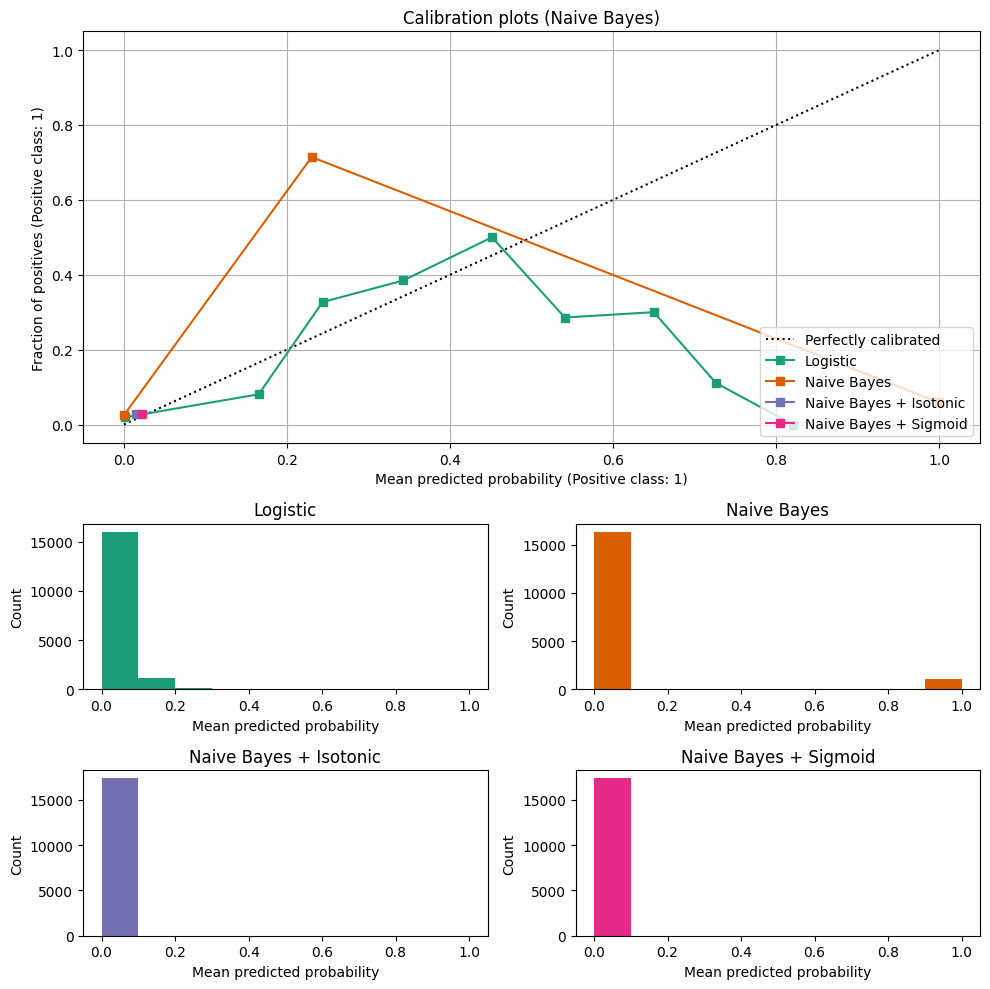

In [34]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins=10,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=10,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [36]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

C:\Users\jmica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jmica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\jmica\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the s

,Brier loss,Log loss,Roc auc,Precision,Recall,F1
Classifier,,,,,,
Logistic,0.025930,0.254327,0.779945,0.227273,0.020964,0.038388
Naive Bayes,0.080799,1.880561,0.708538,0.058768,0.129979,0.080940
Naive Bayes + Isotonic,0.026936,0.132760,0.519550,0.000000,0.000000,0.000000
Naive Bayes + Sigmoid,0.026605,0.124953,0.572491,0.000000,0.000000,0.000000


Here we find all the numeric and discrete attributes in the collisions table, so we can more easily see which should be included in specific tests, or normalized.

In [41]:
# Using your dataframe 'collisions_random_10000_df'
numeric_cols = collisions_random_10000_df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = collisions_random_10000_df.select_dtypes(include=['object']).columns.tolist()

print("Numeric columns: ", numeric_cols)
print("Categorical columns: ", categorical_cols)

Below, we will create a DataFrame containing attributes that are most intuitively associated with collisions. We can also print out a row to see what the data looks like.

In [42]:
collisions_important_df = collisions_random_10000_df[['intersection', 'state_highway_indicator', 'killed_victims', 
    'injured_victims', 'party_count', 'pedestrian_collision', 'bicycle_collision', 'motorcycle_collision', 
    'truck_collision', 'alcohol_involved', 'population', 'weather_1', 'location_type', 'collision_severity', 
    'primary_collision_factor', 'type_of_collision', 'pedestrian_action', 'road_surface', 'road_condition_1', 
    'lighting', 'control_device']]

collisions_important_df['alcohol_involved'] = collisions_important_df['alcohol_involved'].fillna(0) # Filling in 0 for NaN values in alcohol involvement so they can be used in calculations.

print(collisions_important_df.head(1)) # Print one row of the table so we can see what it looks like

## Some Visualizations

Lets make some histograms showing the involvement frequencies of driving condition factors.

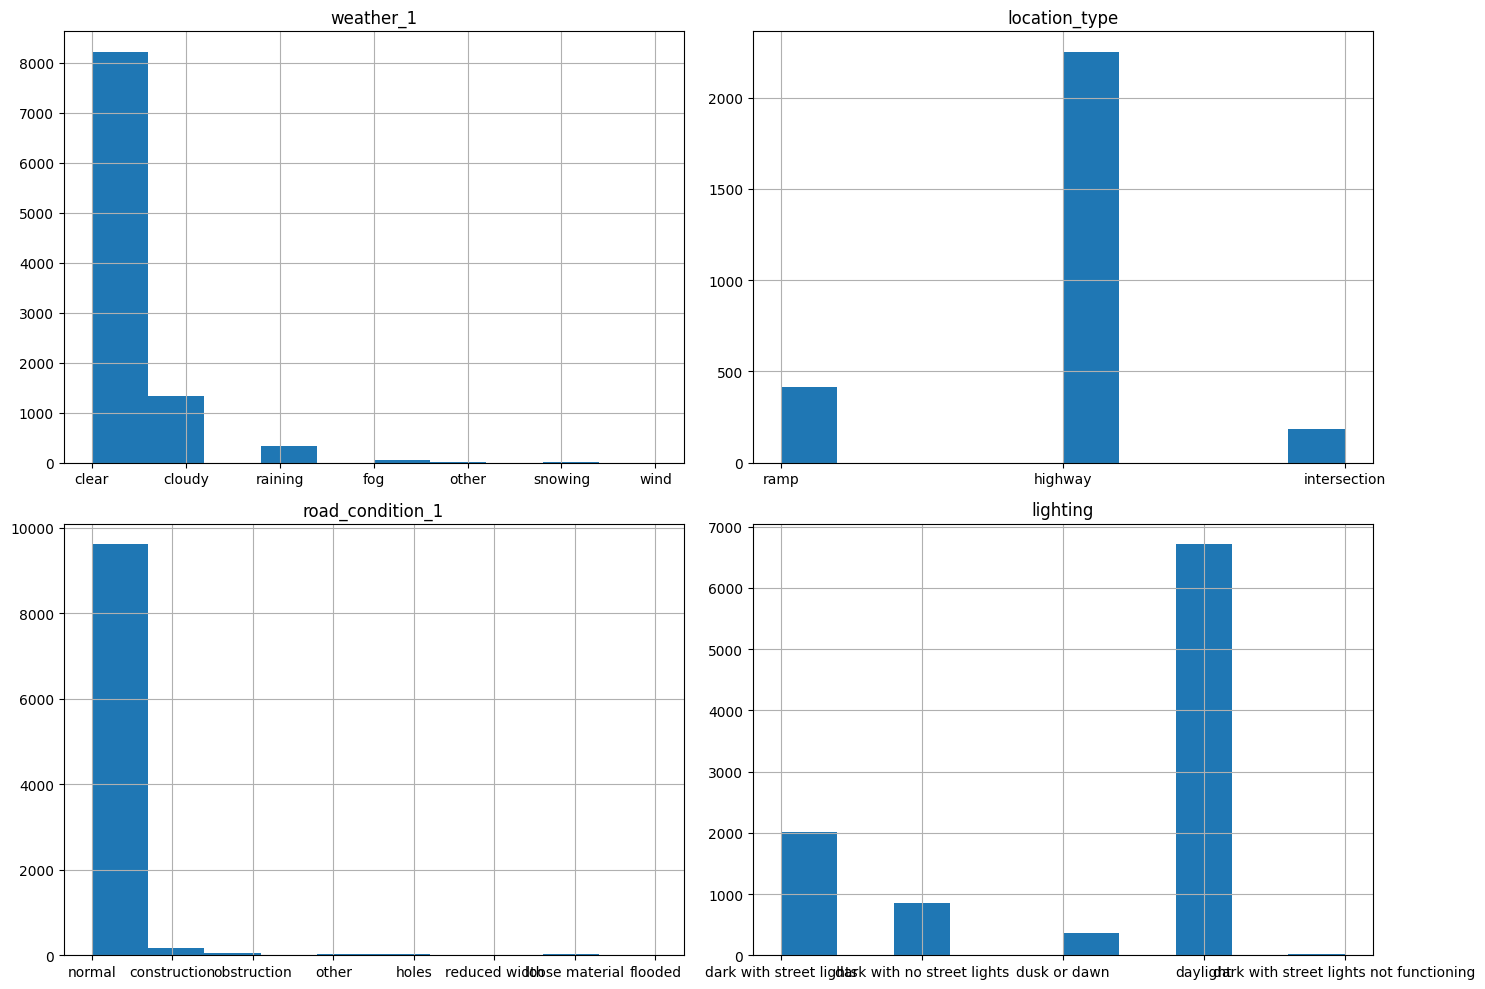

In [85]:
plt.figure(figsize=(15,10))

plt.subplot(2, 2, 1)
collisions_important_df['weather_1'].hist()
plt.title('weather_1')

plt.subplot(2, 2, 2)
collisions_important_df['location_type'].hist()
plt.title('location_type')

plt.subplot(2, 2, 3)
collisions_important_df['road_condition_1'].hist()
plt.title('road_condition_1')

plt.subplot(2, 2, 4)
collisions_important_df['lighting'].hist()
plt.title('lighting')

plt.tight_layout()
plt.show()

Now we should take a look at frequencies of human behaviors that contribute to accidents.

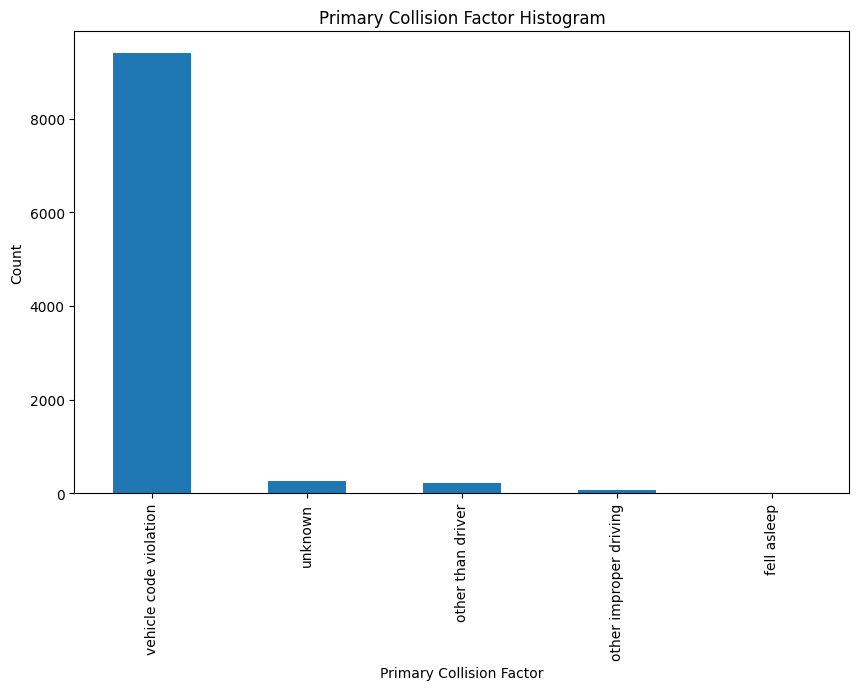

In [18]:
plt.figure(figsize=(10, 6))  # Set the figure size
collisions_important_df['primary_collision_factor'].value_counts().plot(kind='bar')
plt.title('Primary Collision Factor Histogram')  # Set the title
plt.xlabel('Primary Collision Factor')  # Set x-axis label
plt.ylabel('Count')  # Set y-axis label
plt.show()

Below we form a correlation matrix for the numeric attributes of the collisions table. This will help us visualize the relationships that attributes have with each other.

In [19]:
numeric_cols_df = collisions_important_df.select_dtypes(include=[np.number])
# Using your dataframe 'collisions_random_10000_df'
correlation_matrix = numeric_cols_df.corr()

# Printing correlation matrix
print(correlation_matrix)

                         intersection  state_highway_indicator  \
intersection                 1.000000                -0.283647   
state_highway_indicator     -0.283647                 1.000000   
killed_victims              -0.012528                 0.008124   
injured_victims              0.130725                -0.044783   
party_count                  0.041859                 0.012284   
pedestrian_collision         0.048578                -0.102581   
bicycle_collision            0.072667                -0.092591   
motorcycle_collision        -0.008799                 0.020541   
truck_collision             -0.059831                 0.134607   
alcohol_involved            -0.042708                -0.056140   

                         killed_victims  injured_victims  party_count  \
intersection                  -0.012528         0.130725     0.041859   
state_highway_indicator        0.008124        -0.044783     0.012284   
killed_victims                 1.000000         0.0596

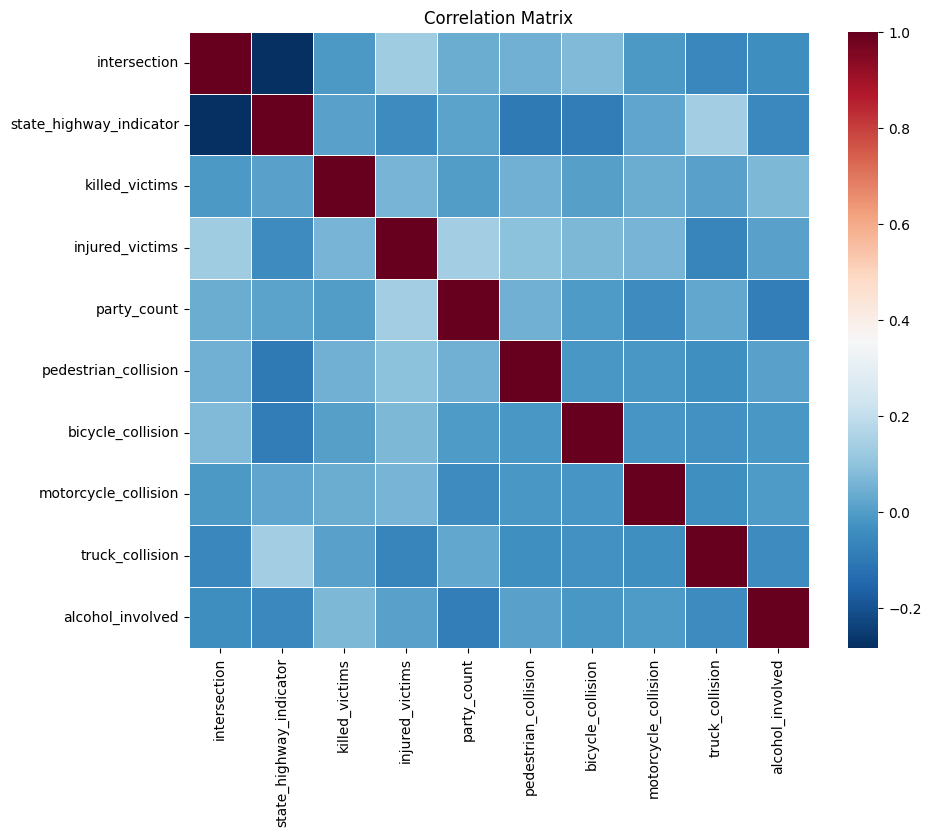

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))  # Optional: You can set the figure size

sns.heatmap(correlation_matrix, 
            xticklabels=correlation_matrix.columns, 
            yticklabels=correlation_matrix.columns, 
            cmap='RdBu_r', 
            annot=False, 
            linewidth=0.5)

plt.title('Correlation Matrix')
plt.show()

In [ ]:
# This cell will defines a first round Data Cube Function(s)
create_data_cube = """SELECT 
    c1, c2, AGGREGATE_FUNCTION(c3)
FROM
    table_name
GROUP BY CUBE(c1 , c2);"""